# LEGO Bricks ML Vision - Training Pipeline Demonstration

This notebook provides a step-by-step demonstration of training the YOLO-based computer vision models for detecting LEGO bricks and studs. The training pipeline showcases how to:

1. Prepare and process LEGO brick/stud datasets
2. Configure and train YOLOv8 models 
3. Evaluate model performance
4. Export models for inference

## Project Overview

The LEGO Bricks ML Vision project uses two distinct computer vision models:
- **Brick Detection Model**: Identifies complete LEGO bricks in images
- **Stud Detection Model**: Identifies individual studs on LEGO bricks

Together, these models enable the full classification pipeline that can identify brick dimensions based on stud patterns.

![Training Pipeline Overview](../docs/assets/images/train_pipeline_diagram.png)

## 1. Setup and Environment Configuration

In [2]:
# Check for "LEGO_BRICKS_ML_VISION" folder in the cwd folder branch

import os
import random
from datetime import datetime
import sys
from pathlib import Path
import subprocess
import rich.logging as rlog
import logging
import math
import matplotlib.image as mpimg

# Set up rich logger
logger = logging.getLogger("notebook_logger")
if not logger.handlers:
    handler = rlog.RichHandler(rich_tracebacks=True, markup=True)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)

def check_repo_clone():
    """
    Check if the cwd name matches the repo name.
    If not, check if the parent folder matches the repo name.
    If not, clone the repo.

    Returns the local repo root path and adds it to the sys.path
    """
    userGithub = "MiguelDiLalla"
    repoGithub = "LEGO_Bricks_ML_Vision"
    repo_url = f"https://github.com/{userGithub}/{repoGithub}.git"

    cwd = Path.cwd()
    cwd_name = cwd.name
    cwd_parent = cwd.parent

    if cwd_name != repoGithub and cwd_parent.name != repoGithub:
        logger.info(f"Cloning [bold blue]{repoGithub}[/bold blue] repository from GitHub...")
        try:
            subprocess.run(["git", "clone", repo_url], check=True, capture_output=True)
            logger.info(f"[bold green]Repository successfully cloned[/bold green]")
            # Add the repo to the sys.path
            sys.path.append(cwd / repoGithub)
            # Change the cwd to the repo root
            os.chdir(cwd / repoGithub)
            return cwd / repoGithub
        except subprocess.CalledProcessError as e:
            logger.error(f"[bold red]Failed to clone repository:[/bold red] {e}")
            logger.error(f"Error output: {e.stderr.decode('utf-8') if e.stderr else 'None'}")
            raise
    else:
        repo_path = cwd if cwd_name == repoGithub else cwd_parent
        logger.info(f"Repository [bold blue]{repoGithub}[/bold blue] already available at: [green]{repo_path}[/green]")
        # Add the repo to the sys.path
        sys.path.append(repo_path)
        # Change the cwd to the repo root (and log it)
        os.chdir(repo_path)
        logger.info(f"Changed the cwd to the repository root at: [green]{repo_path}[/green]")

        
        return repo_path

repo_clone_path = check_repo_clone()


[03/18/25 14:16:41] INFO     Repository LEGO_Bricks_ML_Vision already available at:                ]8;id=749534;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2519827148.py\2519827148.py]8;;\:]8;id=674108;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2519827148.py#53\53]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

                    INFO     Changed the cwd to the repository root at:                            ]8;id=747622;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2519827148.py\2519827148.py]8;;\:]8;id=606707;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2519827148.py#58\58]8;;\
                             c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision                              

In [3]:
def get_requirements(repo_path):
    """Get requirements from requirements.txt file in the repository."""
    req_path = repo_path / "requirements.txt"
    if not req_path.exists():
        logger.warning(f"Requirements file not found at [yellow]{req_path}[/yellow]")
        return None
    
    with open(req_path, "r") as f:
        requirements = f.read().splitlines()
    
    # Filter out comments and empty lines
    requirements = [req for req in requirements if req and not req.startswith('#')]
    logger.info(f"Found [bold green]{len(requirements)}[/bold green] packages in requirements file")
    return requirements

def install_requirements(requirements):
    """Install required packages with logging."""
    if not requirements:
        logger.warning("No requirements to install")
        return False
    
    logger.info("Installing requirements...")
    try:
        # Use --quiet flag to reduce output verbosity
        subprocess.run(["pip", "install", "--quiet", "-r", "requirements.txt"], check=True)
        logger.info("[bold green]Requirements successfully installed[/bold green]")
        return True
    except subprocess.CalledProcessError as e:
        logger.error(f"Failed to install requirements: [bold red]{e}[/bold red]")
        return False

# Get and install requirements
requirements = get_requirements(repo_clone_path)

if requirements:
    logger.info(f"Found [bold]{len(requirements)}[/bold] requirements")
    success = install_requirements(requirements)
    if success:
        logger.info("[bold green]All dependencies ready for LEGO ML Vision project[/bold green]")
else:
    logger.warning("[yellow]No requirements installed. Some functionality may be limited.[/yellow]")

# Log all imports that will be used throughout the notebook
logger.info("Main packages that will be used in this notebook:")
main_packages = [
    "numpy", "torch", "torchvision", "cv2", "PIL", 
    "matplotlib", "ultralytics", "albumentations"
]
for pkg in main_packages:
    if pkg in " ".join(requirements):
        logger.info(f"✓ [green]{pkg}[/green] will be available")

[03/18/25 14:16:44] INFO     Found 16 packages in requirements file                                ]8;id=453241;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=322660;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#13\13]8;;\

                    INFO     Found 16 requirements                                                 ]8;id=688436;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=291156;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#36\36]8;;\

                    INFO     Installing requirements...                                            ]8;id=855718;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=291868;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#22\22]8;;\

[03/18/25 14:16:51] INFO     Requirements successfully installed                                   ]8;id=777008;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=813990;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#26\26]8;;\

                    INFO     All dependencies ready for LEGO ML Vision project                     ]8;id=815478;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=400694;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#39\39]8;;\

                    INFO     Main packages that will be used in this notebook:                     ]8;id=72178;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=638043;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#44\44]8;;\

                    INFO     ✓ numpy will be available                                             ]8;id=984520;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=490280;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

                    INFO     ✓ torch will be available                                             ]8;id=666447;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=660388;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

                    INFO     ✓ torchvision will be available                                       ]8;id=242538;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=667949;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

                    INFO     ✓ matplotlib will be available                                        ]8;id=218360;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=944191;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

                    INFO     ✓ ultralytics will be available                                       ]8;id=160419;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=56104;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

                    INFO     ✓ albumentations will be available                                    ]8;id=512556;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py\2393111203.py]8;;\:]8;id=79600;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\2393111203.py#51\51]8;;\

In [19]:
# Import required libraries
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from IPython.display import Image, display
from ultralytics import YOLO
from PIL import Image as PILImage

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import project modules
from train import get_repo_root, setup_logging, detect_hardware, load_config, cleanup_training_sessions
from train import unzip_dataset, validate_dataset, create_dataset_structure, dataset_split, augment_data
from train import select_model, train_model, zip_and_download_results



In [5]:
# Repository local root

clone_repo_path = get_repo_root()

# Setup logging and load configuration
setup_logging()
config = load_config()

# Detect optimal hardware
device = detect_hardware()
print(f"Training will use device: {device}")

# cleanup pravious training sessions
cleanup_training_sessions(clone_repo_path)

2025-03-18 14:17:18,623 - INFO - Logging initialized for training pipeline ✅
2025-03-18 14:17:18,627 - WARNING - No GPU or MPS device detected. Falling back to CPU. ⚠️


Training will use device: cpu


2025-03-18 14:17:34,978 - INFO - ✅ Emptied: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache ✅
2025-03-18 14:17:35,093 - INFO - ✅ Emptied: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results ✅


## 2. Dataset Exploration

Let's examine our dataset before training. We have separate datasets for brick detection and stud detection.

In [6]:
# Extract and prepare datasets
bricks_dataset_path = unzip_dataset("bricks")
stud_dataset_path = unzip_dataset("studs")


2025-03-18 14:17:35,122 - INFO - Extracting bricks_dataset.zip... ✅
2025-03-18 14:17:43,792 - INFO - Dataset extracted to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks ✅
2025-03-18 14:17:43,798 - INFO - Extracting studs_dataset.zip... ✅
2025-03-18 14:17:53,470 - INFO - Dataset extracted to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs ✅


In [7]:

# Display dataset information
def display_dataset_info(mode):
    images_path, labels_path = validate_dataset(mode)
    image_count = len(list(Path(images_path).glob("*.jpg")))
    label_count = len(list(Path(labels_path).glob("*.txt")))
    
    print(f"\n{mode.capitalize()} Dataset:")
    print(f"- Images path: {images_path}")
    print(f"- Labels path: {labels_path}")
    print(f"- Total images: {image_count}")
    print(f"- Total labels: {label_count}")
    
    
    return images_path, labels_path

bricks_images_path, bricks_labels_path = display_dataset_info("bricks")
studs_images_path, studs_labels_path = display_dataset_info("studs")


2025-03-18 14:17:53,507 - INFO - Starting dataset validation for bricks mode ✅
2025-03-18 14:17:53,561 - INFO - Detected - Images: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\images, Labels: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\YOLO_txt_brick_labels ✅
2025-03-18 14:18:35,771 - WARNING - Error processing image image_555.jpg: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !buf.empty() in function 'cv::imdecode_'
 ⚠️
2025-03-18 14:19:09,230 - INFO - Dataset validation complete: ✅
2025-03-18 14:19:09,233 - INFO - - Valid image-label pairs: 1802 ✅
2025-03-18 14:19:09,234 - INFO - - Removed images: 0 ✅
2025-03-18 14:19:09,236 - INFO - - Removed labels: 1 ✅
2025-03-18 14:19:09,259 - INFO - Starting dataset validation for studs mode ✅
2025-03-18 14:19:09,269 - INFO - Detected - Images: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision


Bricks Dataset:
- Images path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\images
- Labels path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\YOLO_txt_brick_labels
- Total images: 1802
- Total labels: 1802


2025-03-18 14:19:35,110 - WARNING - File was empty: image_0_LegoBrick_1_c79.txt ⚠️
2025-03-18 14:19:35,112 - WARNING - Removing invalid label file image_0_LegoBrick_1_c79.txt: ⚠️
2025-03-18 14:19:35,231 - WARNING - File was empty: image_101_LegoBrick_2_c80.txt ⚠️
2025-03-18 14:19:35,233 - WARNING - Removing invalid label file image_101_LegoBrick_2_c80.txt: ⚠️
2025-03-18 14:19:35,236 - WARNING - File was empty: image_101_LegoBrick_3_c73.txt ⚠️
2025-03-18 14:19:35,238 - WARNING - Removing invalid label file image_101_LegoBrick_3_c73.txt: ⚠️
2025-03-18 14:19:35,242 - WARNING - File was empty: image_102_LegoBrick_0_c77.txt ⚠️
2025-03-18 14:19:35,244 - WARNING - Removing invalid label file image_102_LegoBrick_0_c77.txt: ⚠️
2025-03-18 14:19:35,247 - WARNING - File was empty: image_102_LegoBrick_1_c60.txt ⚠️
2025-03-18 14:19:35,251 - WARNING - Removing invalid label file image_102_LegoBrick_1_c60.txt: ⚠️
2025-03-18 14:19:35,254 - WARNING - File was empty: image_102_LegoBrick_2_c58.txt ⚠️
2025


Studs Dataset:
- Images path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs\images
- Labels path: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\studs\YOLO_txt_studs_labels
- Total images: 1309
- Total labels: 1309


### Visualize Sample Images with Annotations


===== Brick Detection Dataset Samples =====


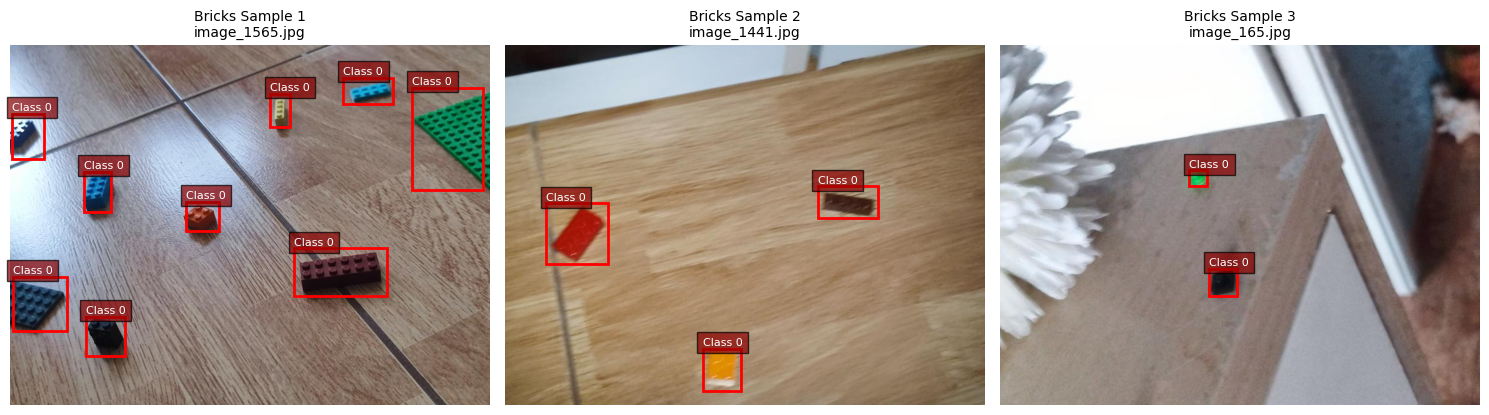


===== Stud Detection Dataset Samples =====


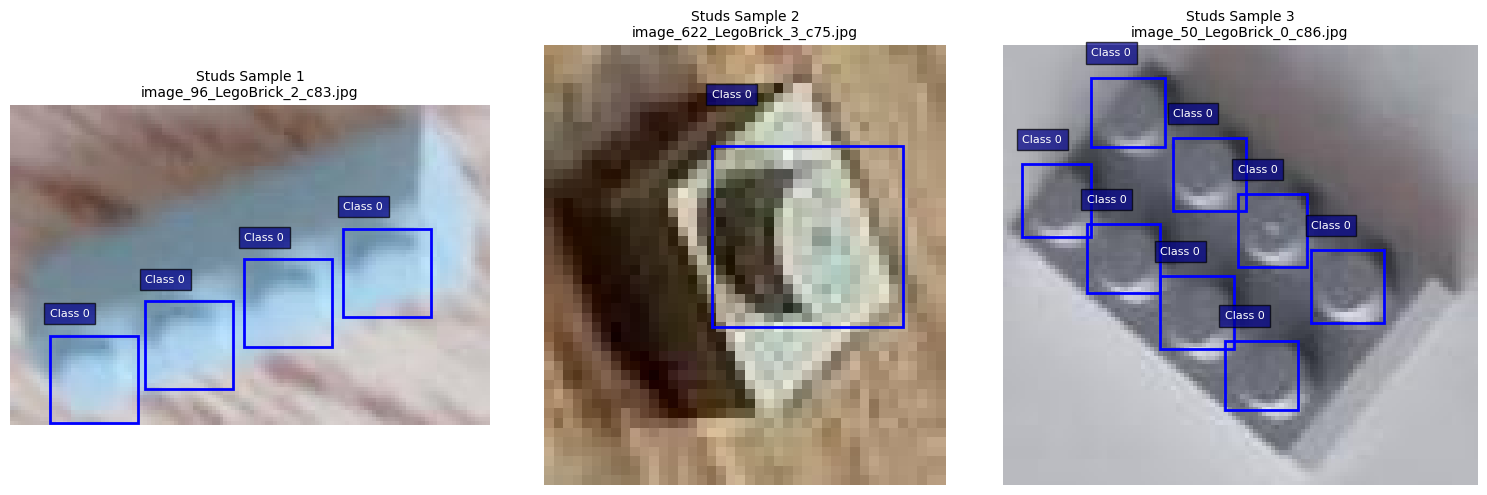

In [8]:
import random

def visualize_sample_with_annotations(images_path, labels_path, mode, num_samples=3):
    """
    Visualize sample images with their YOLO format annotations.
    
    Args:
        images_path: Path to images directory
        labels_path: Path to labels directory 
        mode: Either "bricks" or "studs" to determine visualization style
        num_samples: Number of samples to visualize
    """
    # Get image files and ensure we don't exceed available samples
    image_files = list(Path(images_path).glob("*.jpg"))
    num_samples = min(num_samples, len(image_files))
    samples = random.sample(image_files, num_samples)
    
    # Create figure for horizontal layout
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    if num_samples == 1:
        axes = [axes]  # Make iterable for single sample case
        
    # Define colors based on mode
    colors = {
        "bricks": {"box": "red", "text_bg": "darkred"},
        "studs": {"box": "blue", "text_bg": "darkblue"}
    }
    color = colors.get(mode, {"box": "green", "text_bg": "darkgreen"})
    
    for i, (img_path, ax) in enumerate(zip(samples, axes)):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        
        # Display image
        ax.imshow(img)
        ax.set_title(f"{mode.capitalize()} Sample {i+1}\n{img_path.name}", fontsize=10)
        ax.axis('off')  # Hide axis for cleaner visualization
        
        # Try to find the corresponding label file
        label_file = Path(labels_path) / f"{img_path.stem}.txt"
        
        # If not found directly, check subdirectories
        if not label_file.exists():
            parent_dir = Path(labels_path).parent
            for subdir in ['train', 'val', 'test']:
                alt_path = parent_dir / subdir / "labels" / f"{img_path.stem}.txt"
                if alt_path.exists():
                    label_file = alt_path
                    break
        
        # Load and draw annotations if label file exists
        if label_file.exists():
            with open(label_file, 'r') as f:
                annotations = f.readlines()
            
            # Process each annotation
            for ann in annotations:
                parts = ann.strip().split()
                if len(parts) >= 5:  # Ensure valid YOLO format
                    class_id = int(float(parts[0]))
                    x_center, y_center, w, h = map(float, parts[1:5])
                    
                    # Convert normalized YOLO coordinates to pixel values
                    x1 = int((x_center - w/2) * width)
                    y1 = int((y_center - h/2) * height)
                    x2 = int((x_center + w/2) * width)
                    y2 = int((y_center + h/2) * height)
                    
                    # Draw bounding box
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                        fill=False, edgecolor=color["box"], linewidth=2)
                    ax.add_patch(rect)
                    
                    # Add label text with background
                    ax.text(x1, y1-5, f"Class {class_id}", color='white', fontsize=8,
                           bbox=dict(facecolor=color["text_bg"], alpha=0.7))
        else:
            ax.text(10, 30, "No labels found", color='white', fontsize=10,
                   bbox=dict(facecolor='red', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

# Display dataset samples with annotations
print("\n===== Brick Detection Dataset Samples =====")
visualize_sample_with_annotations(bricks_images_path, bricks_labels_path, "bricks")

print("\n===== Stud Detection Dataset Samples =====")
visualize_sample_with_annotations(studs_images_path, studs_labels_path, "studs")

### Create YOLO training structure:

In [9]:
create_dataset_structure("bricks", repo_clone_path)
create_dataset_structure("studs", repo_clone_path)

2025-03-18 14:20:04,864 - INFO - ✅ Dataset structure created at c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache\split\bricks ✅
2025-03-18 14:20:04,877 - INFO - ✅ Dataset structure created at c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache\split\studs ✅


WindowsPath('c:/Users/User/Projects_Unprotected/LEGO_Bricks_ML_Vision/cache/split/studs')

### Split into train, validation, and test sets:

In [10]:
bricks_dataset_path = dataset_split("bricks", repo_clone_path)
studs_dataset_path = dataset_split("studs", repo_clone_path)

2025-03-18 14:20:04,953 - INFO - Starting dataset split for bricks mode ✅
2025-03-18 14:20:04,967 - INFO - Detected - Images: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\images, Labels: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks\YOLO_txt_brick_labels ✅
2025-03-18 14:20:04,970 - INFO - Source dataset: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/datasets\bricks ✅
2025-03-18 14:20:04,973 - INFO - Output directory: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache/split\bricks ✅
2025-03-18 14:20:04,982 - INFO - Found 1802 images in dataset ✅
2025-03-18 14:20:04,989 - INFO - Files randomly shuffled for unbiased split ✅
2025-03-18 14:20:04,991 - INFO - Split sizes: 1261 train, 360 validation, 181 test ✅
2025-03-18 14:20:04,995 - INFO - Creating YOLO directory structure ✅
2025-03-18 14:20:05,006 - INFO - Copying files to train split... ✅
2025-03-18 14:20:14,152 - INFO - Copied 1261 image-lab

### Augment Training Data using Albumentations:

In [ ]:
augment_data(bricks_dataset_path)
augment_data(studs_dataset_path)

## 3. Training the Brick Detection Model

Now let's train the YOLOv8 model for brick detection. We'll use the training pipeline from `train.py`.

In [ ]:
# Training configuration for the brick detection model
brick_training_params = {
    "dataset_path": bricks_dataset_path,
    "model_path": select_model("bricks", use_pretrained=False),
    "device": device,
    "epochs": 50,
    "batch_size": 16,
    "repo_root": repo_clone_path
}

print("Starting Brick Detection Model Training...")
print(f"Parameters: {brick_training_params}")

# Run the training pipeline (set to shorter epochs for demo purposes)
try:
    brick_results_dir = train_model(**brick_training_params)
    print(f"\nTraining completed. Results saved to: {brick_results_dir}")
except Exception as e:
    print(f"Training error: {e}")

### Visualize Brick Detection Training Results

In [11]:
brick_results_dir = r"results\bricks\training_20250317_135037"

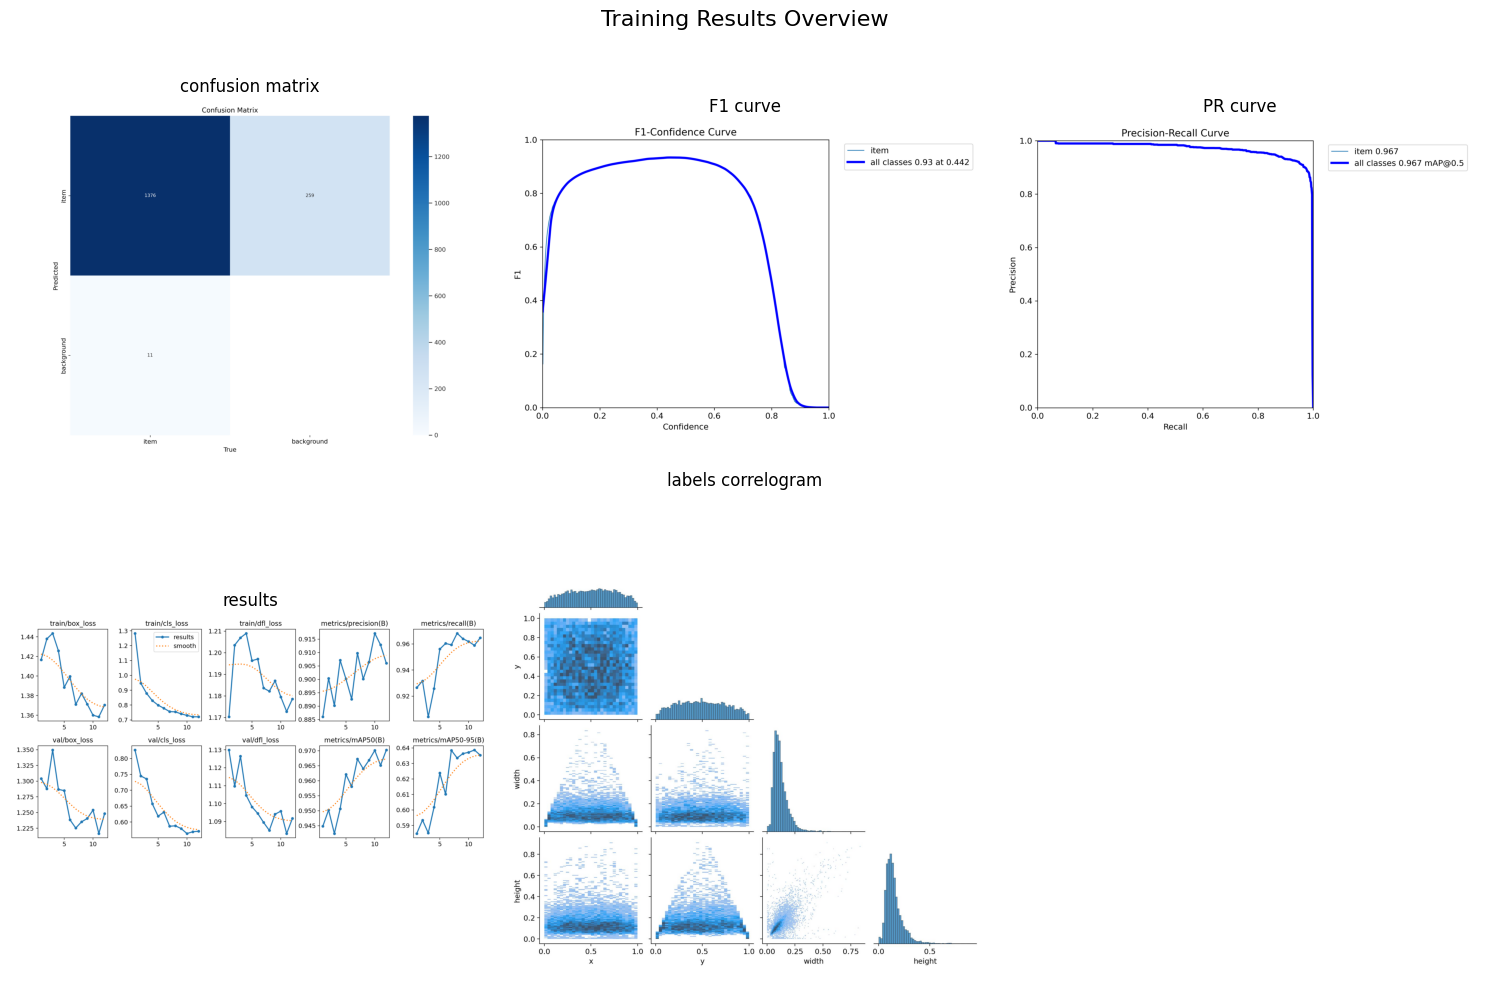

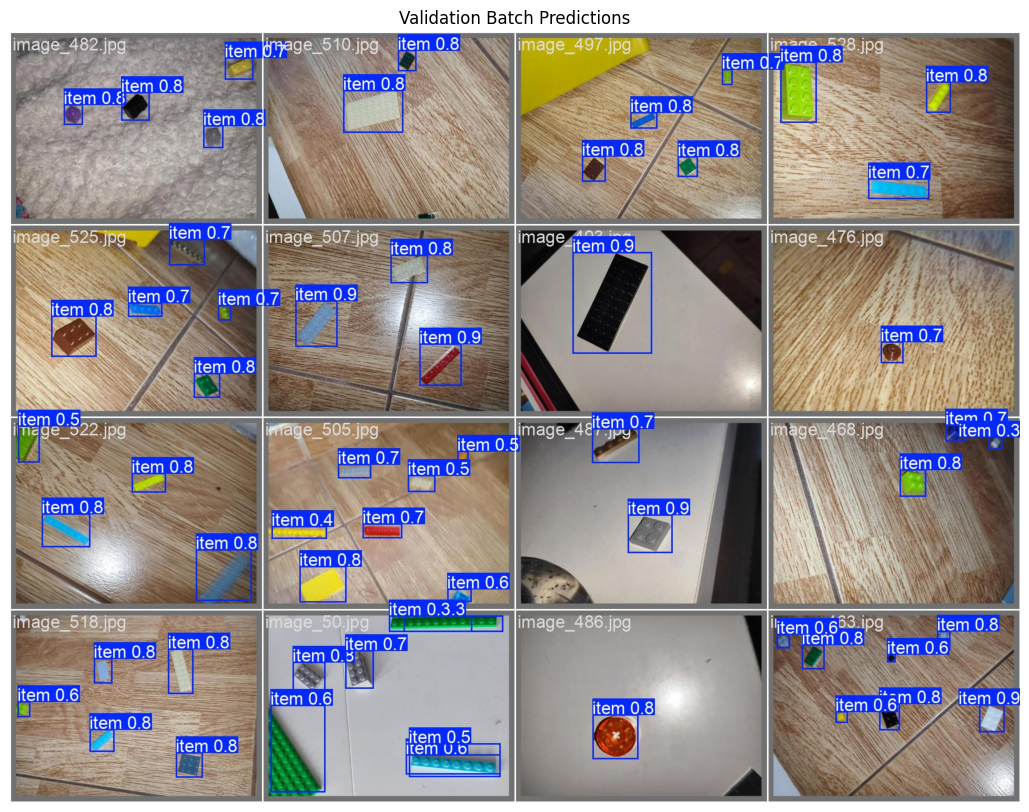

In [12]:
# display a grid of the relevant yolo trainment images

def display_training_results_grid(results_path: str | Path):
    """
    Display key training result visualizations in a grid layout.
    
    Args:
        results_path (str | Path): Path to the YOLO training results folder
    """
    # Key visualization files to display
    viz_files = [
        'confusion_matrix.png',
        'F1_curve.png',
        'PR_curve.png',
        'results.png',
        'labels_correlogram.jpg'
    ]
    
    results_path = Path(results_path)
    
    # Filter existing files
    existing_files = [f for f in viz_files if (results_path / f).exists()]
    
    if not existing_files:
        print("No visualization files found in the specified directory")
        return
    
    # Calculate grid dimensions
    n_images = len(existing_files)
    n_cols = min(3, n_images)  # Max 3 columns
    n_rows = math.ceil(n_images / n_cols)
    
    # Create figure
    fig = plt.figure(figsize=(15, 5*n_rows))
    fig.suptitle('Training Results Overview', size=16)
    
    # Plot each visualization
    for idx, fname in enumerate(existing_files, 1):
        img = mpimg.imread(results_path / fname)
        ax = plt.subplot(n_rows, n_cols, idx)
        ax.imshow(img)
        ax.set_title(fname.replace('.png', '').replace('.jpg', '').replace('_', ' '))
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Display validation batch predictions separately
    val_batch_path = results_path / 'val_batch0_pred.jpg'
    if val_batch_path.exists():
        plt.figure(figsize=(15, 10))
        val_img = mpimg.imread(val_batch_path)
        plt.imshow(val_img)
        plt.title('Validation Batch Predictions')
        plt.axis('off')
        plt.show()

# Example usage:
display_training_results_grid(brick_results_dir)


## 4. Training the Stud Detection Model

Now we'll train the YOLOv8 model for detecting studs on LEGO bricks.

In [ ]:
# Training configuration for the stud detection model
stud_training_params = {
    "dataset_path": studs_dataset_path,
    "model_path": select_model("studs", use_pretrained=False),
    "device": device,
    "epochs": 50,
    "batch_size": 16,
    "repo_root": repo_clone_path
}


print("Starting Stud Detection Model Training...")
print(f"Parameters: {stud_training_params}")

# Run the training pipeline
try:
    stud_results_dir = train_model(**stud_training_params)
    print(f"\nTraining completed. Results saved to: {stud_results_dir}")
except Exception as e:
    print(f"Training error: {e}")

### Visualize Stud Detection Training Results

In [13]:
stud_results_dir = r"results\studs\training_20250317_135955"

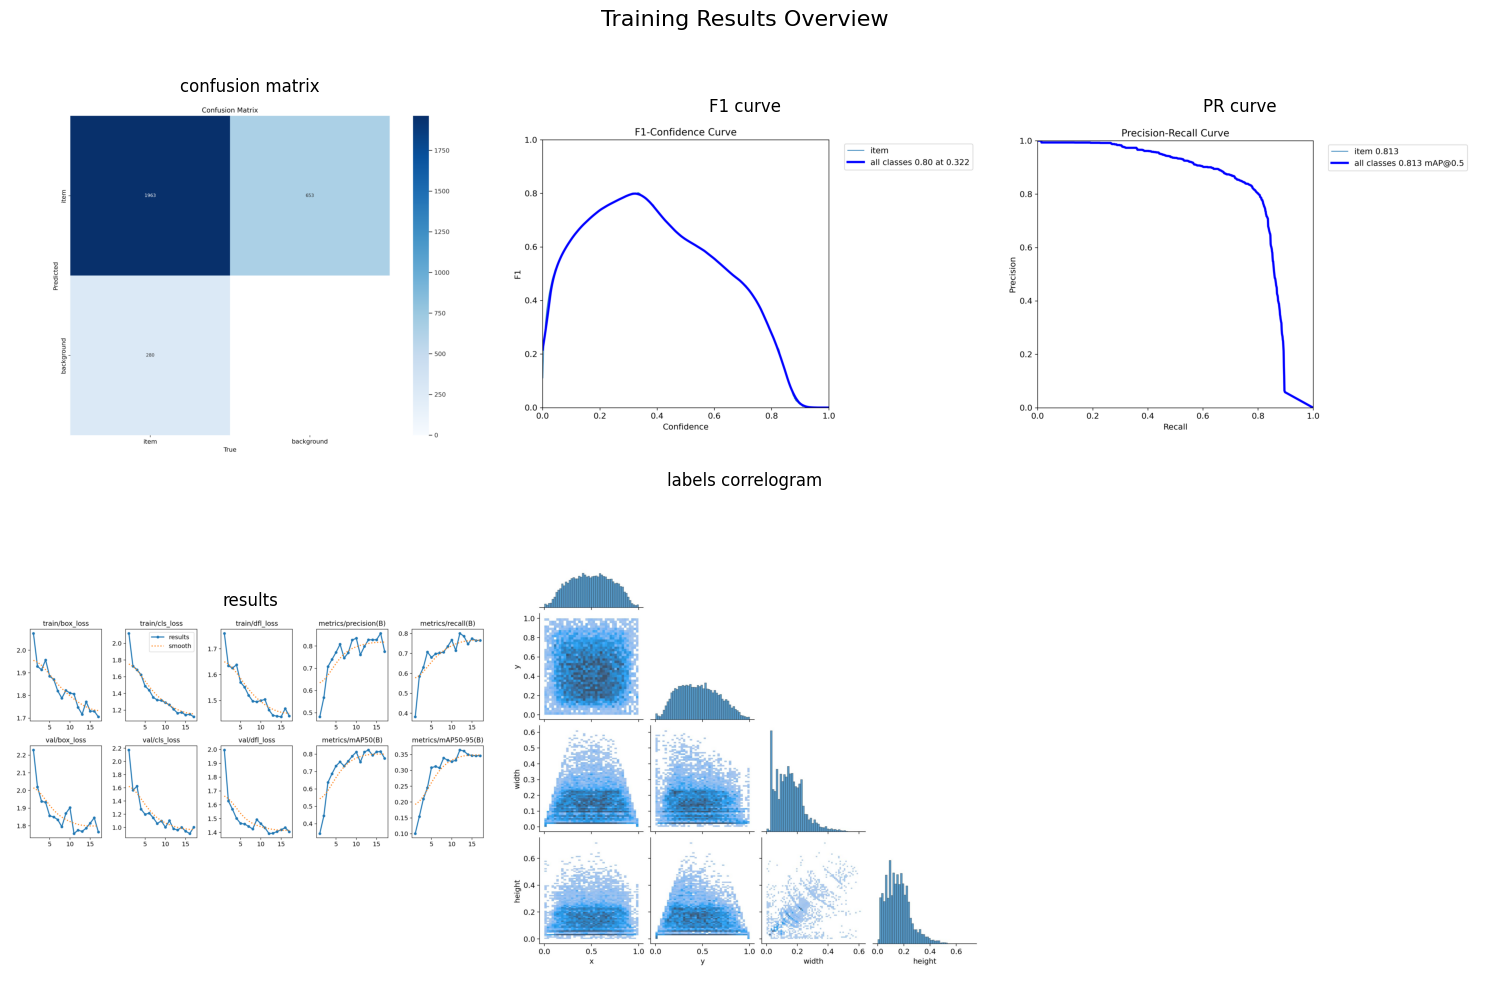

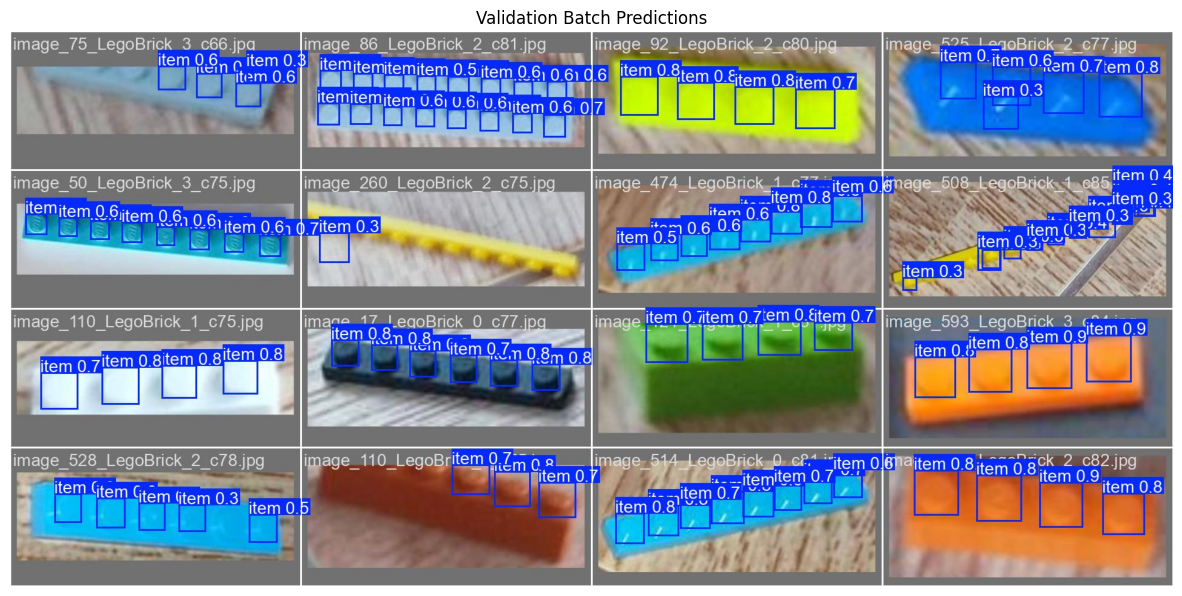

In [14]:
# Display training metrics
display_training_results_grid(stud_results_dir)

## 5. Model Evaluation on Test Images

Let's test our trained models on some unseen images to see how they perform.

In [15]:
# Load the best trained models

def get_model_info(model_path, mode):
    """
    Extract comprehensive information from a YOLO model file
    
    Args:
        model_path (str): Path to the .pt model file
    """
    model = YOLO(model_path)
    
    # Basic model info
    print("=== Model Information ===")
    print(f"Task: {model.task}")  # detect, segment, classify, etc.
    # print(f"Model type: {model.type}")  # n, s, m, l, x (nano to extra large)
    try:
        model.model.names = {0: mode}
    except Exception as e:
        print(f"Error changuin model names: {e}")
    print(f"Class names: {model.names}")
    

    return model

try:
    brick_model_path = Path(brick_results_dir) / "weights" / "best.pt"
    stud_model_path = Path(stud_results_dir) / "weights" / "best.pt"
    
    brick_model = get_model_info(str(brick_model_path), 'Brick')
    stud_model = get_model_info(str(stud_model_path), 'Stud')
    
    print(f"Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {e}")

=== Model Information ===
Task: detect
Class names: {0: 'Brick'}
=== Model Information ===
Task: detect
Class names: {0: 'Stud'}
Models loaded successfully


In [16]:
#repo example images paths:
presentation_bricks_path = str(repo_clone_path / "presentation" / "Test_images" / "BricksPics")
presentation_studs_path = str(repo_clone_path / "presentation" / "Test_images" / "StudsPics")



===== Testing Brick Detection Model =====

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\BricksPics\image_605.jpg: 480x640 6 Bricks, 371.1ms
Speed: 17.3ms preprocess, 371.1ms inference, 22.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\BricksPics\image_14.jpg: 640x480 3 Bricks, 207.1ms
Speed: 8.0ms preprocess, 207.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\BricksPics\image_701.jpg: 480x640 11 Bricks, 178.0ms
Speed: 9.0ms preprocess, 178.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


[03/18/25 14:20:51] INFO     Test results saved to:                                                ]8;id=734908;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\4146872454.py\4146872454.py]8;;\:]8;id=124886;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\4146872454.py#51\51]8;;\
                             results\bricks\test_samples_20250318_142047.png                                       

2025-03-18 14:20:51,883 - INFO - Test results saved to: results\bricks\test_samples_20250318_142047.png ✅


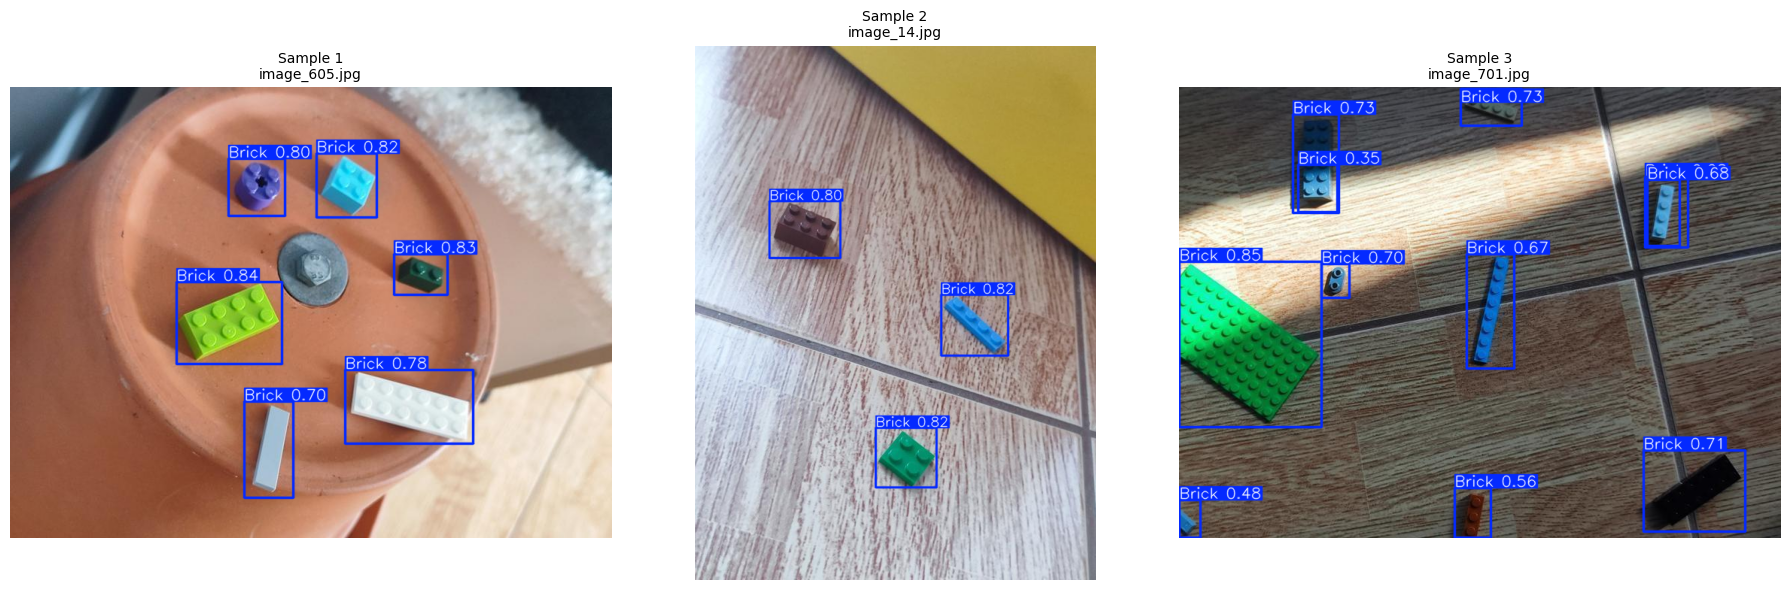


===== Testing Stud Detection Model =====

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\StudsPics\image_119_LegoBrick_1_c77.jpg: 640x576 5 Studs, 162.0ms
Speed: 7.0ms preprocess, 162.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\StudsPics\image_259_LegoBrick_1_c86.jpg: 544x640 13 Studs, 164.1ms
Speed: 7.0ms preprocess, 164.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_images\StudsPics\image_73_LegoBrick_1_c85.jpg: 576x640 3 Studs, 211.0ms
Speed: 6.0ms preprocess, 211.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


[03/18/25 14:20:56] INFO     Test results saved to: results\studs\test_samples_20250318_142053.png ]8;id=203568;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\4146872454.py\4146872454.py]8;;\:]8;id=529630;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\4146872454.py#51\51]8;;\

2025-03-18 14:20:56,756 - INFO - Test results saved to: results\studs\test_samples_20250318_142053.png ✅


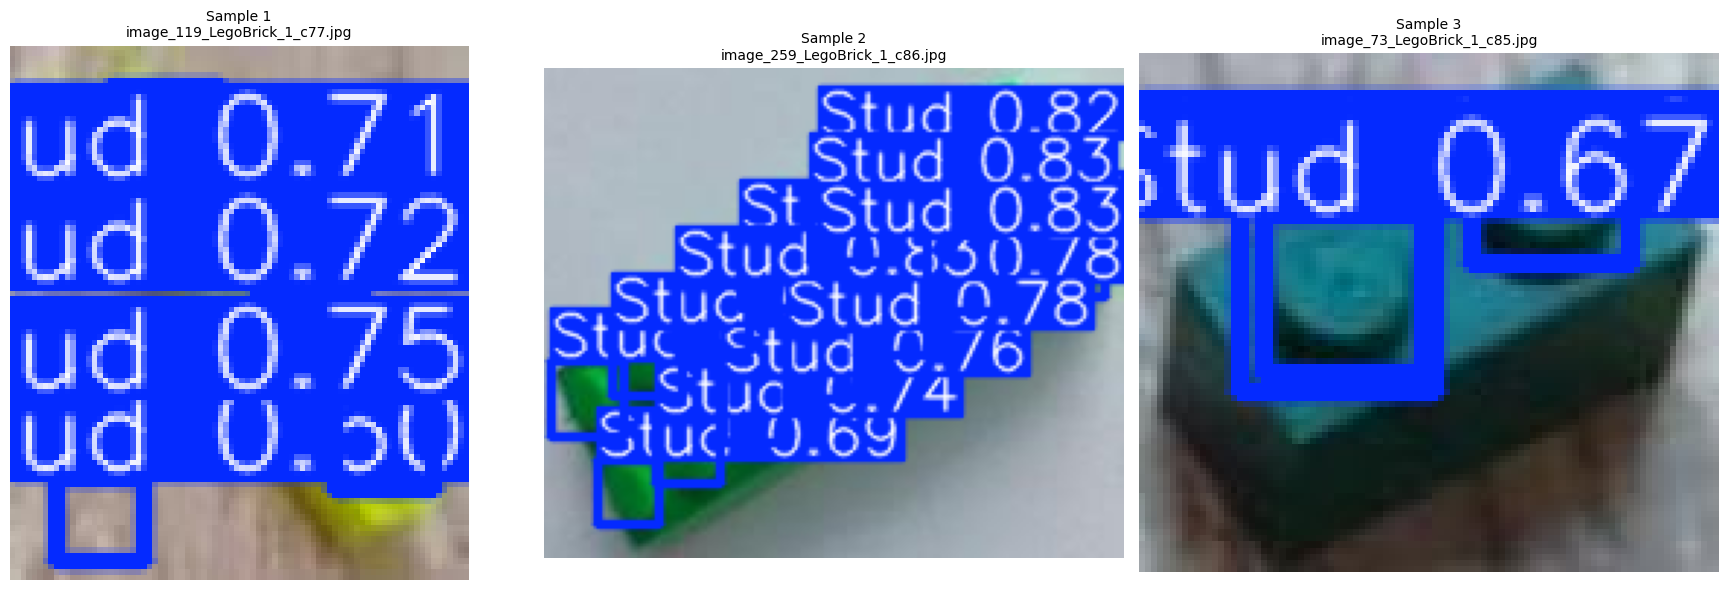

WindowsPath('results/studs/test_samples_20250318_142053.png')

In [17]:
def test_on_images_cv(model, test_images_path, num_samples=3):
    """
    Run inference on test images and display results horizontally.
    
    Args:
        model: YOLO model instance
        test_images_path: Path to test images directory 
        num_samples: Number of samples to process (default=3)
    """
    # Get list of image files
    test_path = Path(test_images_path)
    image_files = list(test_path.glob("*.jpg")) + list(test_path.glob("*.png"))
    
    if not image_files:
        logger.warning(f"No images found in {test_images_path}")
        return
        
    # Select random samples
    num_samples = min(num_samples, len(image_files))
    test_images = random.sample(image_files, num_samples)
    
    # Create figure for horizontal layout
    fig, axes = plt.subplots(1, num_samples, figsize=(6*num_samples, 6))
    if num_samples == 1:
        axes = [axes]
        
    # Process each image
    for idx, (img_path, ax) in enumerate(zip(test_images, axes)):
        # Run inference
        results = model(str(img_path))
        
        # Get the predicted image with boxes
        pred_img = results[0].plot()  # Returns numpy array with annotations
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
        
        # Display with title
        ax.imshow(pred_img)
        ax.set_title(f"Sample {idx+1}\n{img_path.name}", fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    
    # Save the figure to the model's results directory
    mode = "bricks" if model.names.get(0) == "Brick" else "studs"
    save_dir = Path(f"results/{mode}")
    save_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = save_dir / f"test_samples_{timestamp}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    logger.info(f"Test results saved to: {save_path}")
    
    plt.show()
    return save_path

# Example usage:
# Test brick detection model
print("\n===== Testing Brick Detection Model =====")
test_on_images_cv(brick_model, presentation_bricks_path)

# Test stud detection model 
print("\n===== Testing Stud Detection Model =====")
test_on_images_cv(stud_model, presentation_studs_path)


## 6. Complete Inference Pipeline Example

Now let's demonstrate how both models work together in the complete inference pipeline:

[03/18/25 14:33:41] INFO     Processing: image_699.jpg                                              ]8;id=546601;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py\965278481.py]8;;\:]8;id=329631;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py#26\26]8;;\

2025-03-18 14:33:41,462 - INFO - Processing: image_699.jpg ✅


[03/18/25 14:33:55] INFO     Processing: image_14.jpg                                               ]8;id=998384;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py\965278481.py]8;;\:]8;id=498561;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py#26\26]8;;\

2025-03-18 14:33:55,199 - INFO - Processing: image_14.jpg ✅


[03/18/25 14:34:07] INFO     Processing: image_605.jpg                                              ]8;id=550825;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py\965278481.py]8;;\:]8;id=134393;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py#26\26]8;;\

2025-03-18 14:34:07,575 - INFO - Processing: image_605.jpg ✅


[03/18/25 14:34:23] INFO     Results saved to: results\demo_results_20250318_143421.jpg             ]8;id=695181;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py\965278481.py]8;;\:]8;id=627730;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\965278481.py#63\63]8;;\

2025-03-18 14:34:23,111 - INFO - Results saved to: results\demo_results_20250318_143421.jpg ✅


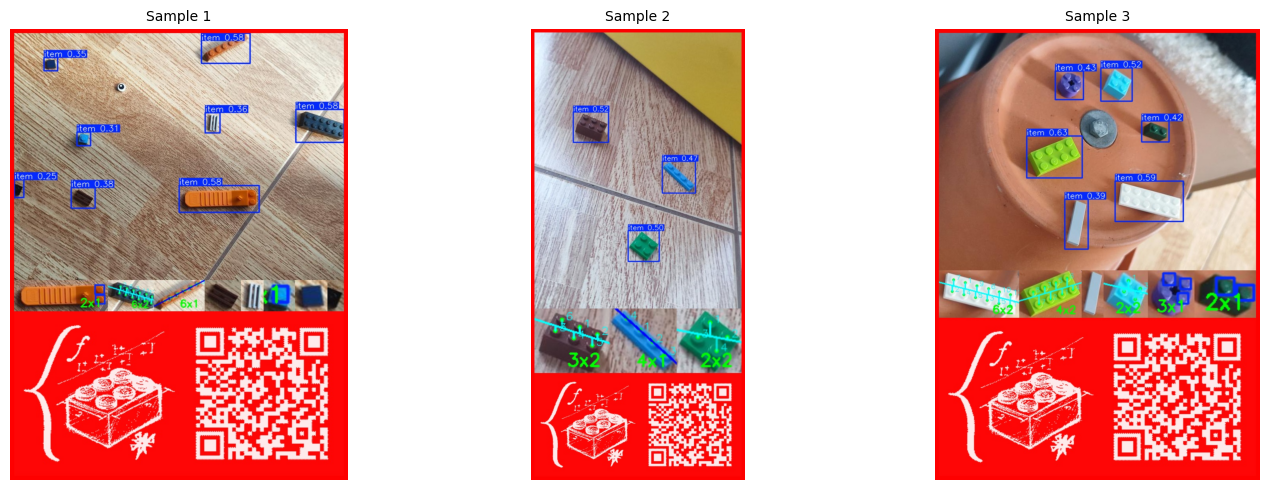

In [26]:
import random
from pathlib import Path
import subprocess
from PIL import Image
from datetime import datetime
import math

# Select and process random test images
import matplotlib.pyplot as plt

def run_lego_inference_demo(num_samples=3):
    """
    Demonstrate the complete LEGO brick analysis pipeline by:
    1. Random test image selection 
    2. Full inference pipeline execution
    3. Results visualization
    """
    # Get test image folder path
    test_folder = Path(presentation_bricks_path)
    image_files = list(test_folder.glob("*.jpg"))
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Process each image through the full pipeline
    results = []
    for img_path in selected_images:
        logger.info(f"Processing: {img_path.name}")
        
        # Run full inference pipeline using CLI
        subprocess.run([
            "python", "lego_cli.py", "infer",
            "--image", str(img_path),
            "--output", "results",
            "--save-annotated",
            "--force-run"
        ], check=True)
        
        # Get result image
        result_path = Path("results") / img_path.stem / "full_analysis.jpg"
        if result_path.exists():
            results.append(Image.open(result_path))

    if not results:
        logger.warning("No results generated")
        return

    # Display results in a grid
    n_cols = min(3, len(results))
    n_rows = math.ceil(len(results) / n_cols)
    fig = plt.figure(figsize=(5*n_cols, 5*n_rows))
    
    for idx, img in enumerate(results, 1):
        ax = plt.subplot(n_rows, n_cols, idx)
        ax.imshow(img)
        ax.set_title(f"Sample {idx}", fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    
    # Save combined visualization
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = Path("results") / f"demo_results_{timestamp}.jpg"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    logger.info(f"Results saved to: {save_path}")
    
    plt.show()

    # Run matadata batch cleanup command 
    # Run metadata batch cleanup command
    subprocess.run([
        "python", "lego_cli.py", "metadata", "clean-batch",
        str(test_folder),
        "--force"
    ], check=True)

# Run demo with 3 random samples
run_lego_inference_demo(num_samples=3)

## 7. Export the training session

Finally, we can export the trained models for deployment. The models can be saved in various formats, including ONNX and TensorRT, for optimized inference on different platforms.

Next, we will zip all the results folder to prepare for deployment:

In [23]:
# zip the results folder
# Zip training results with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_name = f"lego_vision_training_{timestamp}.zip"
output_path = repo_clone_path.parent / results_name

zip_and_download_results(
    Path("results"),  # Source directory containing both brick and stud results
    output_path  # Save in parent directory with descriptive name
)

logger.info(f"Training results exported to: [green]{output_path}[/green]")

2025-03-18 14:28:10,079 - INFO - ✅ Training results compressed: c:\Users\User\Projects_Unprotected\lego_vision_training_20250318_142807.zip ✅


c:\Users\User\Projects_Unprotected\lego_vision_training_20250318_142807.zip

[03/18/25 14:28:10] INFO     Training results exported to:                                         ]8;id=49806;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\3143012732.py\3143012732.py]8;;\:]8;id=35910;file://C:\Users\User\AppData\Local\Temp\ipykernel_11708\3143012732.py#12\12]8;;\
                             c:\Users\User\Projects_Unprotected\lego_vision_training_20250318_1428                 
                             07.zip                                                                                

2025-03-18 14:28:10,089 - INFO - Training results exported to: [green]c:\Users\User\Projects_Unprotected\lego_vision_training_20250318_142807.zip[/green] ✅


In [25]:
# run cleanup command finally to empty repo clone internal temporary data folders
cleanup_training_sessions(clone_repo_path)

2025-03-18 14:29:38,406 - INFO - ✅ Emptied: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\cache ✅
2025-03-18 14:29:38,487 - INFO - ✅ Emptied: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results ✅
